In [1]:
from glob import glob
import numpy as np
from fish.util.fileio import read_image, read_images
import matplotlib.pyplot as plt
plt.style.use('npg')
%matplotlib inline
from skimage.exposure import rescale_intensity
from fish.util.plot import ROI, RoiDrawing
from fish.image.vol import get_stack_freq

fnames = sorted(glob('/groups/ahrens/ahrenslab/davis/data/spim/proc/20180208/6dpf_cy252xcy293_optostim_test_20180208_185317/opto/*mean.tif'))
ref = read_image('/groups/ahrens//ahrenslab/davis/data/spim/proc/20180208/6dpf_cy252xcy293_optostim_test_20180208_185317/reg/anat_reference.tif')
fs_im = get_stack_freq('/groups/ahrens/ahrenslab/davis/data/spim/raw/20180208/6dpf_cy252xcy293_optostim_test_20180208_185317/')[0]
av_window = np.load('/groups/ahrens/ahrenslab/davis/data/spim/proc/20180208/6dpf_cy252xcy293_optostim_test_20180208_185317/opto/av_window.npy')

In [2]:
def minimal_axis(ax, scales, offsets=(0,0), **kwargs):
    ax.axis('off')
    origin = (ax.get_xlim()[0] + offsets[0], ax.get_ylim()[0] + offsets[1])
    
    ax.plot([origin[0], scales[0]], [origin[1], origin[1]], **kwargs)
    ax.plot([origin[0], origin[0]], [origin[1], scales[1]], **kwargs)

In [3]:
%%time
to_load = 0
ims = read_image(fnames[to_load])

CPU times: user 1.38 s, sys: 3.41 s, total: 4.79 s
Wall time: 4.79 s


In [4]:
ims.shape

(65, 46, 512, 1024)

In [5]:
mx = ims.max((0,1))

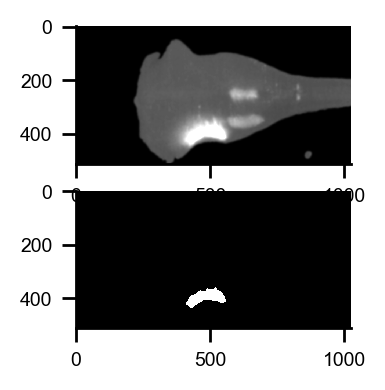

In [66]:
#option 1: infer ROI from max intensity
from scipy.ndimage.filters import gaussian_filter
fig, axs = plt.subplots(figsize=(2,2), dpi=200, nrows=2)
smoothed = gaussian_filter(mx, 3)
perc = 98.9
roi_mask = smoothed > np.percentile(smoothed, perc)
axs[0].imshow(smoothed, cmap='gray', clim=np.percentile(smoothed, (0, perc)))
axs[1].imshow(roi_mask, cmap='gray')

In [184]:
from scipy.ndimage.morphology import binary_dilation
from skimage.morphology import disk
from shapely.geometry import asMultiPoint

roi_mask_morphed = binary_dilation(roi_mask, disk(3))
mulp = asMultiPoint(list(zip(*np.where(roi_mask_morphed)[::-1])))
pol = mulp.buffer(0.5,cap_style=3, join_style=1)
roi_boundary = pol.exterior.xy

In [ ]:
# option 2: draw roi by hand

In [ ]:
fig = plt.figure(figsize=(4,4), dpi=200)
ax = plt.axes([0, 0, 1, 1])
ax.set_title('Draw ROI')
from scipy.ndimage.filters import gaussian_filter
ax.imshow(gaussian_filter(mx, [3,3]), cmap='gray')
roi_draw = RoiDrawing(ax, mx)

In [ ]:
# get the roi timeseries

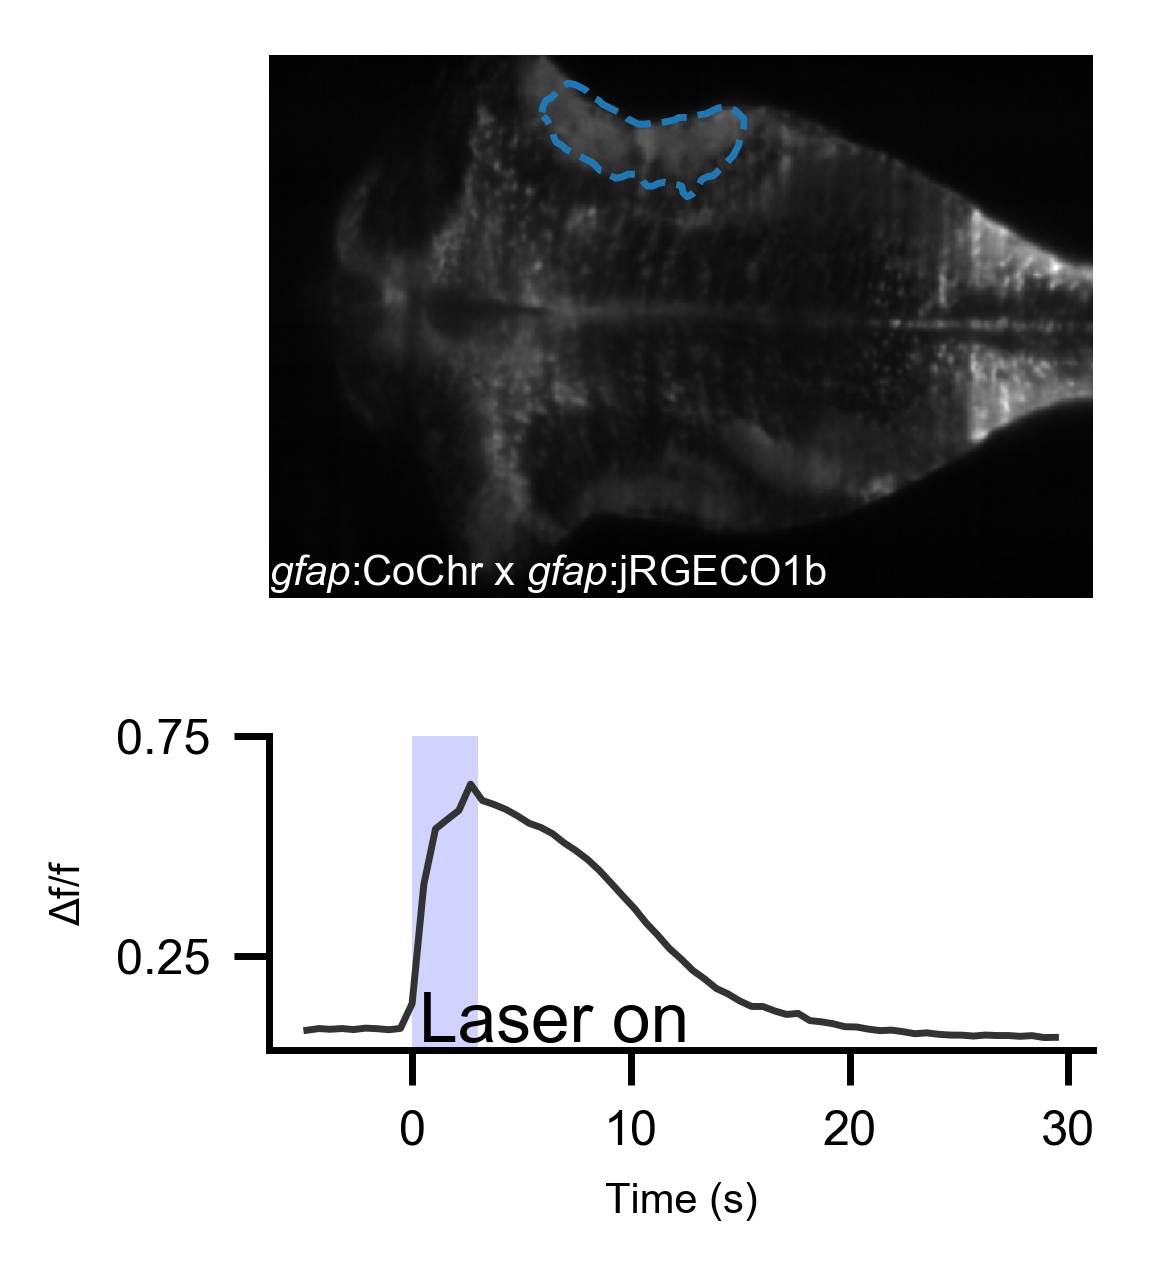

In [240]:
%matplotlib inline
from skimage.color import gray2rgb
from skimage.transform import downscale_local_mean
import matplotlib as mpl
label_size = 6

z = 20
ts_mean = np.array([t[roi_mask].mean() for t in ims[:,z]])
ref_smoothed = gaussian_filter(downscale_local_mean(ref[z], (2,2)).astype('float32'), 1)
fig, axs = plt.subplots(nrows=2, ncols=1, gridspec_kw = {'height_ratios' : (2,1)}, figsize=(8.5/4, 11/4), dpi=500)

axs[0].imshow(ref_smoothed, origin='lower', cmap='gray')
axs[0].plot(roi_boundary[0][::6],roi_boundary[1][::6], linestyle ='--')

axs[0].axis('off')
axs[0].set_xlim(200,ref_smoothed.shape[1] - 200)
axs[0].set_ylim(50,ref_smoothed.shape[0] - 50)
axs[0].text(axs[0].get_xlim()[0],axs[0].get_ylim()[0] + 10, r'$gfap$:CoChr x $gfap$:jRGECO1b', color='w', fontsize=label_size)

plr_ts = av_window
laser_on = np.where(plr_ts==0)[0] / fs_im
laser_off = laser_on + 3
stim_window = np.array([laser_on, laser_off])
ylim = -0.005, .05
x_axis = plr_ts / fs_im
laser_on_inds = ~np.logical_and(x_axis > 0, x_axis < ( laser_off - laser_on))

# plot pre, post stim separately
x_pre = x_axis < 0
x_post = x_axis > (laser_off - laser_on)
axs[1].plot(x_axis, ts_mean, color=[.2,.2,.2], linewidth=1)

scale_x, scale_y = .5, .025
axs[1].axvspan(0, laser_off - laser_on, zorder=0, alpha = .6, facecolor=(180/255,180/255,1), edgecolor=None)
axs[1].set_ylabel(r'$\Delta$f/f', fontsize=label_size)
axs[1].set_xlabel('Time (s)', fontsize=label_size)
`
axs[1].text(0.3, np.diff(ylim), 'Laser on')
axs[1].set_yticks(axs[1].get_yticks()[1::2])
plt.savefig('/groups/ahrens/ahrenslab/projects/ngm/presentation/resource/opto_stim_validation.pdf')